In [79]:
# importing the libraries
import pandas as pd
import numpy as np
from tqdm import tqdm

# for reading and displaying images
from skimage.io import imread
from skimage.transform import resize
import matplotlib.pyplot as plt
# %matplotlib inline

# for creating validation set
from sklearn.model_selection import train_test_split

# for evaluating the model
from sklearn.metrics import accuracy_score

# PyTorch libraries and modules
import torch
from torch.autograd import Variable
from torch.nn import Linear, ReLU, CrossEntropyLoss, Sequential, Conv2d, MaxPool2d, Module, Softmax, BatchNorm2d, Dropout
from torch.optim import Adam, SGD

# torchvision for pre-trained models
from torchvision import models

In [80]:
from google.colab import drive
drive.mount("/content/gdrive")

Mounted at /content/gdrive


In [101]:
train=pd.read_csv('/content/gdrive/MyDrive/emergency_vs_non-emergency_dataset/emergency_train.csv')
train.head()



,image_names,emergency_or_not
0,1503.jpg,0
1,1420.jpg,0
2,1764.jpg,0
3,1356.jpg,0
4,1117.jpg,0


In [84]:
train['image_names']

0       1503.jpg
1       1420.jpg
2       1764.jpg
3       1356.jpg
4       1117.jpg
          ...   
1641    1638.jpg
1642    1095.jpg
1643    1130.jpg
1644    1294.jpg
1645     860.jpg
Name: image_names, Length: 1646, dtype: object

In [102]:
train_img = []
for img_name in tqdm(train['image_names']):
    # defining the image path
    image_path = '/content/gdrive/MyDrive/emergency_vs_non-emergency_dataset/images/' + img_name
    # reading the image
    img = imread(image_path)
    # normalizing the pixel values
    img = img/255
    # resizing the image to (224,224,3)
    img = resize(img, output_shape=(224,224,3), mode='constant', anti_aliasing=True)
    # converting the type of pixel to float 32
    img = img.astype('float32')
    # appending the image into the list
    train_img.append(img)

# converting the list to numpy array
train_x = np.array(train_img)
train_x.shape

100%|██████████| 1646/1646 [00:25<00:00, 65.00it/s]


(1646, 224, 224, 3)

It is a Non-Emergency vehicle


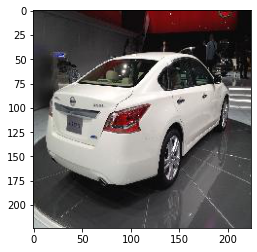

In [103]:
index = 140
plt.imshow(train_x[index])
if (train['emergency_or_not'][index] == 1):
    print('It is an Emergency vehicle')
else:
    print('It is a Non-Emergency vehicle')

In [104]:
train_y=train['emergency_or_not'].values
print(len(train_y))
train_x


1646


array([[[[3.68627459e-01, 3.76470596e-01, 2.82352954e-01],
         [3.84313732e-01, 3.92156869e-01, 3.09803933e-01],
         [4.31372553e-01, 4.35294122e-01, 3.80392164e-01],
         ...,
         [1.01960786e-01, 2.23529413e-01, 2.31372550e-01],
         [9.01960805e-02, 2.31372550e-01, 2.31372550e-01],
         [5.49019612e-02, 2.07843140e-01, 2.03921571e-01]],

        [[4.47058827e-01, 4.54901963e-01, 3.60784322e-01],
         [4.03921574e-01, 4.11764711e-01, 3.29411775e-01],
         [3.72549027e-01, 3.76470596e-01, 3.21568638e-01],
         ...,
         [8.62745121e-02, 1.96078435e-01, 2.07843140e-01],
         [9.01960805e-02, 2.11764708e-01, 2.19607845e-01],
         [7.45098069e-02, 2.07843140e-01, 2.03921571e-01]],

        [[3.52941185e-01, 3.60784322e-01, 2.66666681e-01],
         [4.03921574e-01, 4.11764711e-01, 3.29411775e-01],
         [4.11764711e-01, 4.15686280e-01, 3.60784322e-01],
         ...,
         [6.66666701e-02, 1.41176477e-01, 1.64705887e-01],
         [

In [105]:
train_x, val_x, train_y, val_y = train_test_split(train_x, train_y, test_size = 0.1, random_state = 13, stratify=train_y)


In [106]:
train_x.shape,train_y.shape

((1481, 224, 224, 3), (1481,))

In [107]:
val_x.shape,val_y.shape

((165, 224, 224, 3), (165,))

In [108]:
train_x = train_x.reshape(1481, 3, 224, 224)
train_x  = torch.from_numpy(train_x)

# converting the target into torch format
train_y = train_y.astype(int)
train_y = torch.from_numpy(train_y)

# shape of training data
train_x.shape, train_y.shape


(torch.Size([1481, 3, 224, 224]), torch.Size([1481]))

In [109]:
val_x = val_x.reshape(165, 3, 224, 224)
val_x  = torch.from_numpy(val_x)

# converting the target into torch format
val_y = val_y.astype(int)
val_y = torch.from_numpy(val_y)

# shape of validation data
val_x.shape, val_y.shape

(torch.Size([165, 3, 224, 224]), torch.Size([165]))

In [110]:
model = models.vgg16_bn(pretrained=True)


Downloading: "https://download.pytorch.org/models/vgg16_bn-6c64b313.pth" to /root/.cache/torch/hub/checkpoints/vgg16_bn-6c64b313.pth


In [111]:
for param in model.parameters():
    param.requires_grad = False

In [112]:
if torch.cuda.is_available():
    model = model.cuda()


In [113]:
model.classifier[6] = Sequential(
                      Linear(4096, 2))
for param in model.classifier[6].parameters():
    param.requires_grad = True

In [115]:
batch_size = 128

# extracting features for train data
data_x = []
label_x = []

inputs,labels = train_x, train_y

for i in tqdm(range(int(train_x.shape[0]/batch_size)+1)):
    input_data = inputs[i*batch_size:(i+1)*batch_size]
    label_data = labels[i* batch_size:(i+1)*batch_size]
    # input_data , label_data = Variable(input_data.cuda()),Variable(label_data.cuda())
    x = model.features(input_data)
    data_x.extend(x.data.cpu().numpy())
    label_x.extend(label_data.data.cpu().numpy())


100%|██████████| 12/12 [14:44<00:00, 73.73s/it]


In [116]:
# extracting features for validation data
data_y = []
label_y = []

inputs,labels = val_x, val_y

for i in tqdm(range(int(val_x.shape[0]/batch_size)+1)):
    input_data = inputs[i*batch_size:(i+1)*batch_size]
    label_data = labels[i*batch_size:(i+1)*batch_size]
    # input_data , label_data = Variable(input_data.cuda()),Variable(label_data.cuda())
    x = model.features(input_data)
    data_y.extend(x.data.cpu().numpy())
    label_y.extend(label_data.data.cpu().numpy())

100%|██████████| 2/2 [01:38<00:00, 49.12s/it]


In [117]:
# converting the features into torch format
x_train  = torch.from_numpy(np.array(data_x))
x_train = x_train.view(x_train.size(0), -1)
y_train  = torch.from_numpy(np.array(label_x))
x_val  = torch.from_numpy(np.array(data_y))
x_val = x_val.view(x_val.size(0), -1)
y_val  = torch.from_numpy(np.array(label_y))

In [119]:
x_train.shape,y_train

(torch.Size([1481, 25088]), tensor([1, 1, 0,  ..., 1, 0, 0]))